## Challenge 2

Demonstrate how one might devise an observational campaign to capture this tipping point.

The aim of this challenge is for you to use the datset provided to design an observational campaign based on fixed "mooring" sites. 
Select a small number of candidate locations, extract and analyse the local time series and/or depth profiles at each site, and use this to decide where you would place moorings, for how long, and what frequency you might want them at in order to identify a tipping point. 
___

This time you are going to use a 3D datatset. Use what you have learnt in Challenge 1 to define the path where the data is stored, then acess it and inspect it.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Your dataset path and  filename are /gws/pw/j07/workshop/ARIA_src_data/ 
# VERIFY_eORCA025_MED_UKESM_3D_19900101_20710101_grid_T.nc

import xarray as xr 

path = "/gws/pw/j07/workshop/ARIA_src_data/"
t_path3d = path + "VERIFY_eORCA025_MED_UKESM_3D_19900101_20710101_grid_T.nc"

ds = xr.open_dataset(t_path3d, chunks={"x":40,"y":40})

ds

<xarray.Dataset> Size: 93GB
Dimensions:               (time_counter: 972, deptht: 75, axis_nbounds: 2,
                           y: 400, x: 400)
Coordinates:
  * deptht                (deptht) float32 300B 0.5058 1.556 ... 5.902e+03
    nav_lat               (y, x) float32 640kB dask.array<chunksize=(40, 40), meta=np.ndarray>
    nav_lon               (y, x) float32 640kB dask.array<chunksize=(40, 40), meta=np.ndarray>
    time_centered         (time_counter) object 8kB dask.array<chunksize=(486,), meta=np.ndarray>
  * time_counter          (time_counter) object 8kB 1990-01-16 00:00:00 ... 2...
Dimensions without coordinates: axis_nbounds, y, x
Data variables:
    deptht_bounds         (time_counter, deptht, axis_nbounds) float32 583kB dask.array<chunksize=(1, 75, 2), meta=np.ndarray>
    so                    (time_counter, deptht, y, x) float32 47GB dask.array<chunksize=(1, 38, 40, 40), meta=np.ndarray>
    thetao                (time_counter, deptht, y, x) float32 47GB dask.array<chunksize=(1, 38, 40, 40), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) object 16kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) object 16kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/14)
    name:         MEANS_OUT/eORCA025_MED_UKESM_1m_20560101_20601230_grid_T
    description:  ocean T grid variables
    title:        ocean T grid variables
    Conventions:  CF-1.6
    timeStamp:    2021-Dec-01 04:57:56 GMT
    uuid:         b4e5f0e1-aaec-483c-a176-dbb2aaa65929
    ...           ...
    jbegin:       0
    nj:           76
    file_name:    eORCA025_MED_UKESM_1m_20560101_20601230_grid_T_206001-20600...
    TimeStamp:    01/12/2021 10:09:20 +0000
    history:      Mon Nov 24 21:47:32 2025: ncks -d deptht,0,74 -d x,801,1200...
    NCO:          netCDF Operators version 5.3.3 (Homepage = http://nco.sf.ne...

You will notice that your dataset now has three dimensions: latitude, longitude, and depth.     

This will reflect in the size of your variable (eg. the salinity (so) has dimensions (time_counter, deptht, y, x))

By default xarray loads the enitre dataset into memory. This can cause issues with overloading memory. We can invoke dask using the "chunks" argument, which bring lazy loading into play. This loads data in chunks, only using the chunks that are needed thus reducing memory demands.

Now, let's look at your data in more details.    
By selecting a specific depth level, you can plot that layer as a two-dimensional field, similarly to what you have done in Challenge1:

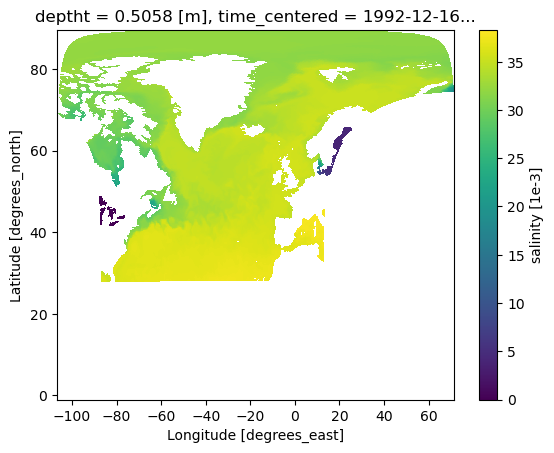

In [2]:
# Select a date and a depth level
# Use the sel() function to select the data based on values of a specific dimension.
# Use the isel() function to select the data based on the index position. 

# This is an example for december 1992:
# 3D salinity field for that month: (deptht, y, x)
so_3d = ds.so.sel(time_counter="1992-12")

# 2D field for the same time at a specific depth level (deptht dimension). Change the deptht value to look at different depths levels.
Salinity = ds.so.sel(time_counter="1992-12").isel(deptht=0) 
# alternatives: 
# Salinity = ds.so.sel(time_counter="1992-12").sel(deptht=0, method="nearest") # in this case, deptht is in meters (not an index). 
# Salinity = ds.so.isel(time_counter=35).isel(deptht=0) # in this case the time is not the date but its index. 

# mask the data to cover the land regions using the domain file. 
dom_cfg = xr.open_dataset(path + "verify.domcfg.nc") # open the domain
Salinity = Salinity.where(dom_cfg.top_level ==1) # apply maks 

# Finally plot your salinity. 
Salinity.plot(x="nav_lon", y="nav_lat")


You will notice that in very deep regions, some areas of the salinity are all 0. This is because you are 'below' the bathymetry (seafloor) level. There is not water (therefor data) there.     
Usually, when running a model you will have a mask file, with 3d areas of land that are not calculated (Similar to what you did previously in Challenge one when you masked the surface with surf_rad_y2000m01 = surf_rad_y2000m01.where(dom_cfg.top_level == 1) ).     

In this case we do not have a mask, but as you know the salinity values are always positive you can create and 'artificial maks' by setting all salinity values that are 0 (therefore too deep), as NAN (Not A Values), and all other values to 1. 

Keep in mind that you can not do this for the temperature field, which can be 0 in water points. 

In [3]:

# Mask for the full dataset. 4D (time_counter, deptht, y, x)
mask = xr.where(ds.so == 0, float("nan"), 1.0)


Now select one mooring location.       
This will be one point in space (lat/lon), but all depth available at that location. Start with only one point in time. Is that enough to see a tipping point?    

Note that there are different options for you here:  

picking a random index for your latitude and longitude will work, but it might be difficult to picture where your point is.      
eg. if you want the point of index (50,100) this should work: salinity_profile = ds.so.sel(time_counter="1992-12").isel(y=100, x=50) 

The sel() function will not work directly with nav_lat/nav_lon.       
Therefore, this will NOT work: salinity_profile = ds.so.sel(time_counter="1992-12").sel(nav_lat=70, nav_lon=10, method="nearest")

In [4]:
# One more recomendable way to pick a point is to first select a latitutde and longitude you want to investigate, for eg. latitude = 70N, longitude= 10E: 
target_lat = 70
target_lon = 10

# Then find the closest model point to these coordinates 
dist = ((ds.nav_lat - target_lat)**2 + (ds.nav_lon - target_lon)**2)**0.5

# Find the index of the closest point by: 
dist_1d = dist.stack(points=("y", "x")).load() # Turning the 2D grid (y, x) into a 1D list of points called "points". Each entry in "points" corresponds to the a set of (y, x).
ip = dist_1d.argmin("points") # getting index of the point with minimum distance (closest point) 

# Recover the original (y, x) indices from the stacked MultiIndex
j = dist_1d["y"].isel(points=ip).item()
i = dist_1d["x"].isel(points=ip).item()

#Use (j, i) with isel to get the vertical profile (all depths, one time)
salinity_profile = ds.so.sel(time_counter="1992-12").isel(y=j, x=i)

#print(salinity_profile)
#print(salinity_profile.deptht.values)

In [5]:
# # Alternatively, to find the closest point you can also:
# # Keep only the minimum-distance point, and drop everything else
# closest = dist.where(dist == dist.min(), drop=True)
# # closest now has shape (y: 1, x: 1) if the minimum is unique

# # Read back the y, x indices (these are the integer indices of the grid)
# j = int(closest["y"])
# i = int(closest["x"])

# # Vertical profile at that nearest grid point
# salinity_profile = ds.so.sel(time_counter="1992-12").isel(y=j, x=i)

Now, first check that the point you selected is where you expect it to:

Text(0.5, 1.0, 'Salinity with profile location (red x)')

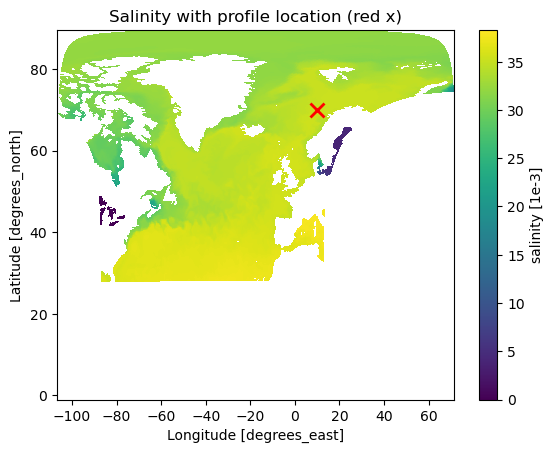

In [6]:
import matplotlib.pyplot as plt

# Lon/lat of the chosen point
pt_lon = ds.nav_lon.isel(y=j, x=i)
pt_lat = ds.nav_lat.isel(y=j, x=i)

# Plot Salinity and overlay the red 'x'
fig, ax = plt.subplots()

Salinity.plot(x="nav_lon", y="nav_lat", ax=ax)
ax.plot(pt_lon, pt_lat, "rx", markersize=10, mew=2)

ax.set_title("Salinity with profile location (red x)")


Then plot the vertical profile of the point that you selected. This uses the raw data (not the masked ones)    

Text(0, 0.5, 'Depth (m)')

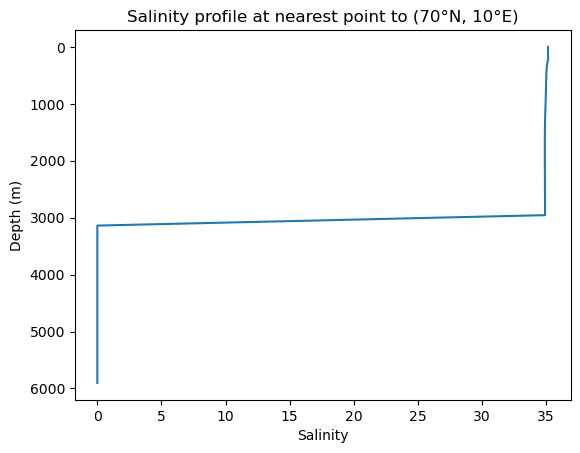

In [7]:
# Simple profile: salinity vs depth
# import matplotlib.pyplot as plt

salinity_profile.plot(y="deptht")   # or x="deptht" if you prefer depth on x-axis
plt.gca().invert_yaxis()            # optional: depth increasing downward
plt.title("Salinity profile at nearest point to (70°N, 10°E)")
plt.xlabel("Salinity")
plt.ylabel("Depth (m)")


You can in the plot above that the deepest levels are all 0. There are bottom levels 'below' the bahymetry where depth are all set to 0. Use the mask to ignore these, as they are not useful data.

Text(0, 0.5, 'Depth (m)')

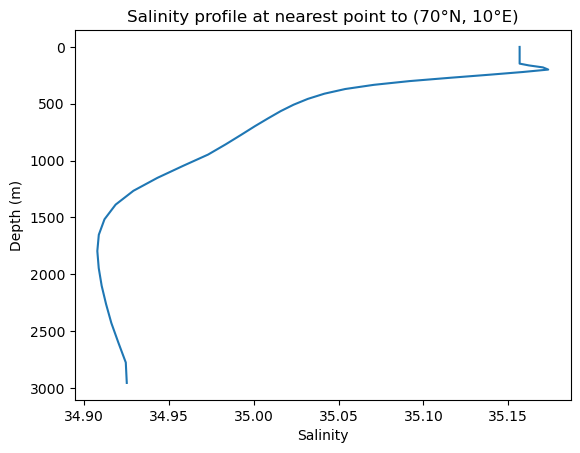

In [8]:
# Extract the 1D mask profile at the same time and point
mask_profile = mask.sel(time_counter="1992-12").isel(y=j, x=i)

# Apply the mask: keep values where mask == 1, set others to NaN
salinity_profile_masked = salinity_profile.where(mask_profile == 1)

# Plot masked profile
salinity_profile_masked.plot(y="deptht")   # or x="deptht"
plt.gca().invert_yaxis()
plt.title("Salinity profile at nearest point to (70°N, 10°E)")
plt.xlabel("Salinity")
plt.ylabel("Depth (m)")

# # scatterplot (alternative)
# fig, ax = plt.subplots()
# ax.scatter(
#     salinity_profile_masked.values,
#     salinity_profile_masked["deptht"].values,
# )
# ax.invert_yaxis()
# ax.set_title("Salinity profile at nearest point to (70°N, 10°E)")
# ax.set_xlabel("Salinity")
# ax.set_ylabel("Depth (m)")

Now, instead of a depth profile, try looking at a time series. 
Use the same location you have worked with so far and pick one depth and plot the entire time series for your variable.     
Can you see the tipping point now? 

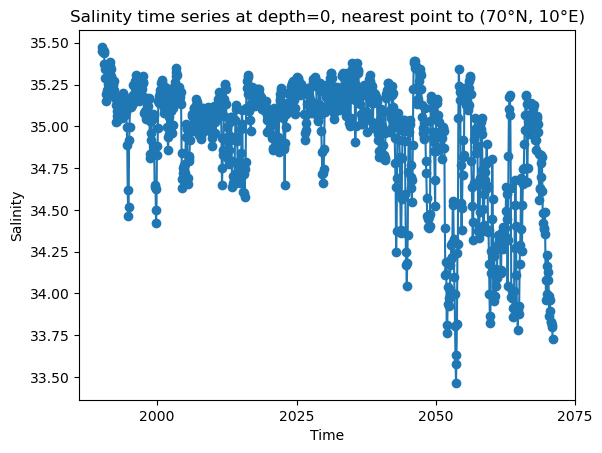

In [9]:
# Time series at surface (deptht=0) for the selected grid point (j, i)
salinity_ts = ds.so.isel(deptht=0, y=j, x=i)   # dims: time_counter

# plot the timeseries 
#import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# Line + scatter time series
salinity_ts.plot(ax=ax)
ax.scatter(salinity_ts["time_counter"].values,
           salinity_ts.values)

ax.set_title("Salinity time series at depth=0, nearest point to (70°N, 10°E)")
ax.set_xlabel("Time")
ax.set_ylabel("Salinity")

plt.show()

You might want to investigate a few depths at once. Are surface and deep water behaving similarly? 

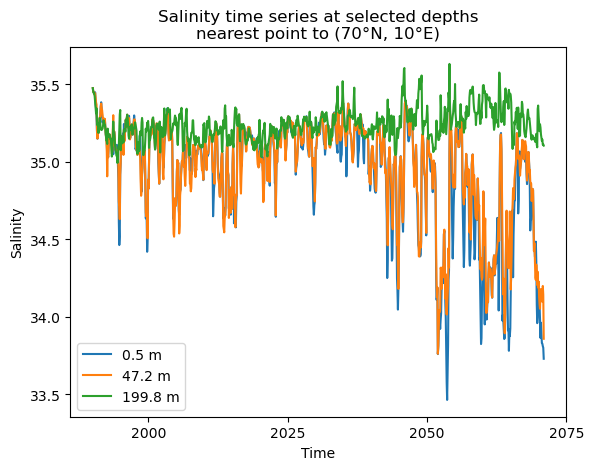

In [10]:
# Hand-picked depths in metres
depths = [0, 50, 200]   # change as you like

fig, ax = plt.subplots()
for d in depths:
    # time series at depth ~ d, for point (j, i)
    salinity_ts = ds.so.sel(deptht=d, method="nearest").isel(y=j, x=i) # find the closest depth to the values you choose
    label = f"{float(salinity_ts.deptht.values):.1f} m"     # label with the actual depth level used. (:.1f is the to round at significant figure)
    salinity_ts.plot(ax=ax, label=label)

ax.set_title("Salinity time series at selected depths\nnearest point to (70°N, 10°E)")
ax.set_xlabel("Time")
ax.set_ylabel("Salinity")
ax.legend()
plt.show()

To properly investigate your variable at a mooring site, you may want to examine its evolution over time at all depths simultaneously.    
This is commonly done with hovmoller plots. 

First let's select the data at one point, for all depths and for the entire timeseries. Think of what you expect the size of your subsample to be.

In [11]:
# Extract salinity and mask at the chosen horizontal point (j, i)
salinity_hov = ds.so.isel(y=j, x=i)   # dims: ('time_counter', 'deptht')
mask_hov     = mask.isel(y=j, x=i)    # same dims. This uses the 4D mask you have generated at the start.

# Apply mask to you salinity slice.
salinity_hov_masked = salinity_hov.where(mask_hov == 1)

# (optional sanity check)
print(salinity_hov_masked.dims)       # should be ('time_counter', 'deptht')


('time_counter', 'deptht')


Now plot you data. 

Can you see the tipping point?    
Is it easier to spot that in the previous examples?

Text(0, 0.5, 'Depth (m)')

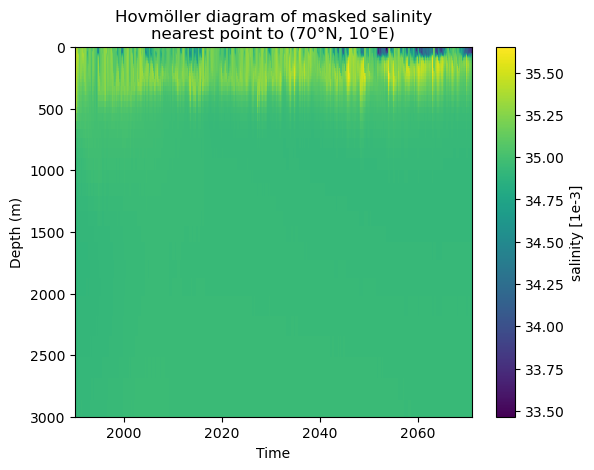

In [12]:
# Hovmöller plot: time vs depth
fig, ax = plt.subplots()

salinity_hov_masked.plot(
    x="time_counter",
    y="deptht",
    ax=ax,
)
# x-limits: first and last time (you can change these)
t0 = salinity_hov_masked["time_counter"].values[0]
t1 = salinity_hov_masked["time_counter"].values[-1]
ax.set_xlim(t0, t1)
# y-limits: e.g. top 500 m (and flip so 0 is at the top)
ax.set_ylim(3000, 0)

ax.set_title("Hovmöller diagram of masked salinity\nnearest point to (70°N, 10°E)")
ax.set_xlabel("Time")
ax.set_ylabel("Depth (m)")

Now select a few different points over the model domain and have a look a them.
Can you find examples of point where the tipping point is clearer and some where the tipping point is harder to see?    
Select a few point that you think are a good mooring site. 

In [13]:
print('write your code here')

write your code here
